In [26]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

## Klee-Minty testing

In [81]:
def klee_minty_sample(n=3)->dict:

    """
    return: 
    a dictionary about klee-minty pattern:
    ### obj: 
        the objective function obj@x that wanted to maximize
    ### subject_to:
        the subject function: inequality@x <= upperbound
    
    ### value_bound: 
        the tuple of bound of each x_i 
    """


    ret = {}
    obj = np.array(list(10**(n-i-1) for i in range(n)))
    formula = []
    bounded = []
    for i in range(n):
        this_i_formula = [0]*n
        for j in range(n):
            if j < i:
                this_i_formula[j]=(2*(10**(i-j)))
            elif j == i:
                this_i_formula[j]=(1)
            else:
                this_i_formula[j]=(0)
        formula.append(this_i_formula)
        bounded.append(100**i)
    
    ret['subject_to'] = {
        'inequality': np.array(formula),
        'upperbound':np.array(bounded)
    }
    ret['value_bound'] = tuple(
        list((0,None) for _ in range(n))
    )
    ret['objective'] = obj

    return ret


def print_statement(linprog_statement:dict):
    for k, v in linprog_statement.items():
        if isinstance(v, dict):
            print(k)
            for ki, vi in v.items():
                print(f"{ki}")
                print(f"{vi}")
        else:
            print(f"{k} : {v}")

In [83]:
# Test if klee-minty is right
linprog_statement = klee_minty_sample(n = 4)
print_statement(linprog_statement)

subject_to
inequality
[[   1    0    0    0]
 [  20    1    0    0]
 [ 200   20    1    0]
 [2000  200   20    1]]
upperbound
[      1     100   10000 1000000]
value_bound : ((0, None), (0, None), (0, None), (0, None))
objective : [1000  100   10    1]


In [123]:
def LP_klee_minty_test(n_range, pivot:str, max_iter:int=5000, progress_bar:bool=True)->tuple:
    """
    Test scipy.optimize.linprog max n on klee-minty example. 
    """
    mx = 0
    exception = []
    status = -1
    spending_time = 0
    range_bar = range(n_range[0], n_range[1])
    if progress_bar:
        range_bar = tqdm(range_bar)
    for i in range_bar:
        linprog_statement = klee_minty_sample(n = i)
        s = time.time()
        r = linprog(
            c = -linprog_statement['objective'],
            A_ub=linprog_statement['subject_to']['inequality'],
            b_ub = linprog_statement['subject_to']['upperbound'],
            method='revised simplex',
            options={'pivot' : pivot, 'maxiter':max_iter}
        )
        e = time.time()
        spending_time = e-s

        if progress_bar:
            range_bar.set_postfix(
                {'iters':r['nit'], "max":-r['fun'], 
                'time':spending_time})
                
        if r['status']==1:
            mx = i 
            status = r['status']
            break
        elif r['status']:
            exception.append((i, r['status']))
    if progress_bar:
        range_bar.close()
    return mx, status, spending_time, exception
    

In [125]:
def simplex_different_pivot_kleep_minty(
    n_range=(2,1000), pivot='mrc'
):
    mx_list = []
    time_list = []
    st_list = []
    ex_set = []
    max_iter = list(i for i in range(5000, 50000, 1000))
    bar = tqdm(max_iter)
    n_lower = n_range[0]
    for i in bar :
        mx, st, t, ex = LP_klee_minty_test(
            n_range=(n_lower,n_range[1]),pivot=pivot, max_iter=i,
            progress_bar=False
        )
        mx_list.append(mx)
        st_list.append(st)
        time_list.append(t)
        ex_set.append(ex)
        bar.set_postfix(
            {'lower':n_lower, 'st':st,
            'max iter':i, 'n':mx, 'time':t
            }
        )
        n_lower = mx
        if t/60 > 5.0:
            break
    limitation_max_iter = max_iter[:len(time_list)]
    result = pd.DataFrame(
    {
        'max_iter':limitation_max_iter,'n':mx_list,
        'time':time_list,'status':st_list, 
        'exception':ex_set
    }
    )
    result.to_csv(
        f"{pivot}_klee_minty_test.csv", encoding='utf-8',index=False
    )


#### pivot : mrc

In [126]:
simplex_different_pivot_kleep_minty(pivot='mrc')

  0%|          | 0/45 [00:00<?, ?it/s]C:\Users\brian\AppData\Local\Temp\ipykernel_14288\1733131615.py:15: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  r = linprog(
100%|██████████| 45/45 [05:08<00:00,  6.86s/it, lower=16, st=1, max iter=49000, n=16, time=11]  


#### pivot : bland

In [127]:
simplex_different_pivot_kleep_minty(pivot='bland')

  0%|          | 0/45 [00:00<?, ?it/s]C:\Users\brian\AppData\Local\Temp\ipykernel_14288\1733131615.py:15: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  r = linprog(
  2%|▏         | 1/45 [00:04<03:02,  4.15s/it, lower=2, st=1, max iter=5000, n=18, time=1.21]d:\py\lib\site-packages\scipy\optimize\_linprog_rs.py:401: LinAlgWarning: Diagonal number 19 is exactly zero. Singular matrix.
  B.update(ab[i][l], j)       # modify basis
d:\py\lib\site-packages\scipy\optimize\_linprog_rs.py:401: LinAlgWarning: Diagonal number 20 is exactly zero. Singular matrix.
  B.update(ab[i][l], j)       # modify basis
100%|██████████| 45/45 [04:43<00:00,  6.31s/it, lower=21, st=1, max iter=49000, n=21, time=12.3]


In [117]:
linprog_statement = klee_minty_sample(n = 13)

r = linprog(
    c = -linprog_statement['objective'],
    A_ub=linprog_statement['subject_to']['inequality'],
    b_ub = linprog_statement['subject_to']['upperbound'],
    method='revised simplex',
    options={'pivot' : 'bland', 'maxiter':100000}
)
print(r['status'])
print(-r['fun'])

C:\Users\brian\AppData\Local\Temp\ipykernel_14288\3703505685.py:3: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  r = linprog(


4
1.000000000000001e+24


In [112]:
linprog_statement = klee_minty_sample(n = 15)

r = linprog(
    c = -linprog_statement['objective'],
    A_ub=linprog_statement['subject_to']['inequality'],
    b_ub = linprog_statement['subject_to']['upperbound'],
    method='revised simplex',
    options={'pivot' : 'bland', 'maxiter':100000}
)
print(r['status'])

C:\Users\brian\AppData\Local\Temp\ipykernel_14288\1357121531.py:3: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  r = linprog(


0


### Comparsion

In [10]:
def klee_minty_differnt_n_iteration(n_range, pivot, max_iter=10000):
    iter_mx, st, time_list = [], [], []
    for i in range(n_range[0], n_range[1]):
        linprog_statement = klee_minty_sample(n = i)
        s = time.time()
        r = linprog(
            c = -linprog_statement['objective'],
            A_ub= linprog_statement['subject_to']['inequality'],
            b_ub = linprog_statement['subject_to']['upperbound'],
            method='revised simplex',
            options={"pivot":pivot,"maxiter":max_iter}
        )
        e = time.time()
        iter_mx.append(r['nit'])
        time_list.append(e-s)
        st.append(r['status'])
    return iter_mx, st, time_list


In [14]:
mrc_iter_mx, mrc_st, mrc_timelist = klee_minty_differnt_n_iteration(
    n_range=(2,10), pivot='mrc'
)
mrc_N_2_9 = pd.DataFrame(
    {
        'n':list(i for i in range(2,10)),
        'iters':mrc_iter_mx,
        'times':mrc_timelist,
        'status':mrc_st
        
    }
)
mrc_N_2_9.to_csv(
    'cmp_mrc.csv', encoding='utf-8', index=False
)

C:\Users\brian\AppData\Local\Temp\ipykernel_14288\78385745.py:6: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  r = linprog(


In [15]:
bland_iter_mx, bland_st, bland_timelist = klee_minty_differnt_n_iteration(
    n_range=(2,10), pivot='bland'
)
bland_N_2_9 = pd.DataFrame(
    {
        'n':list(i for i in range(2,10)),
        'iters':bland_iter_mx,
        'times':bland_timelist,
        'status':bland_st
        
    }
)
bland_N_2_9.to_csv(
    'cmp_bland.csv', encoding='utf-8', index=False
)

C:\Users\brian\AppData\Local\Temp\ipykernel_14288\78385745.py:6: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  r = linprog(


In [19]:
x= list(i for i in range(2,10))

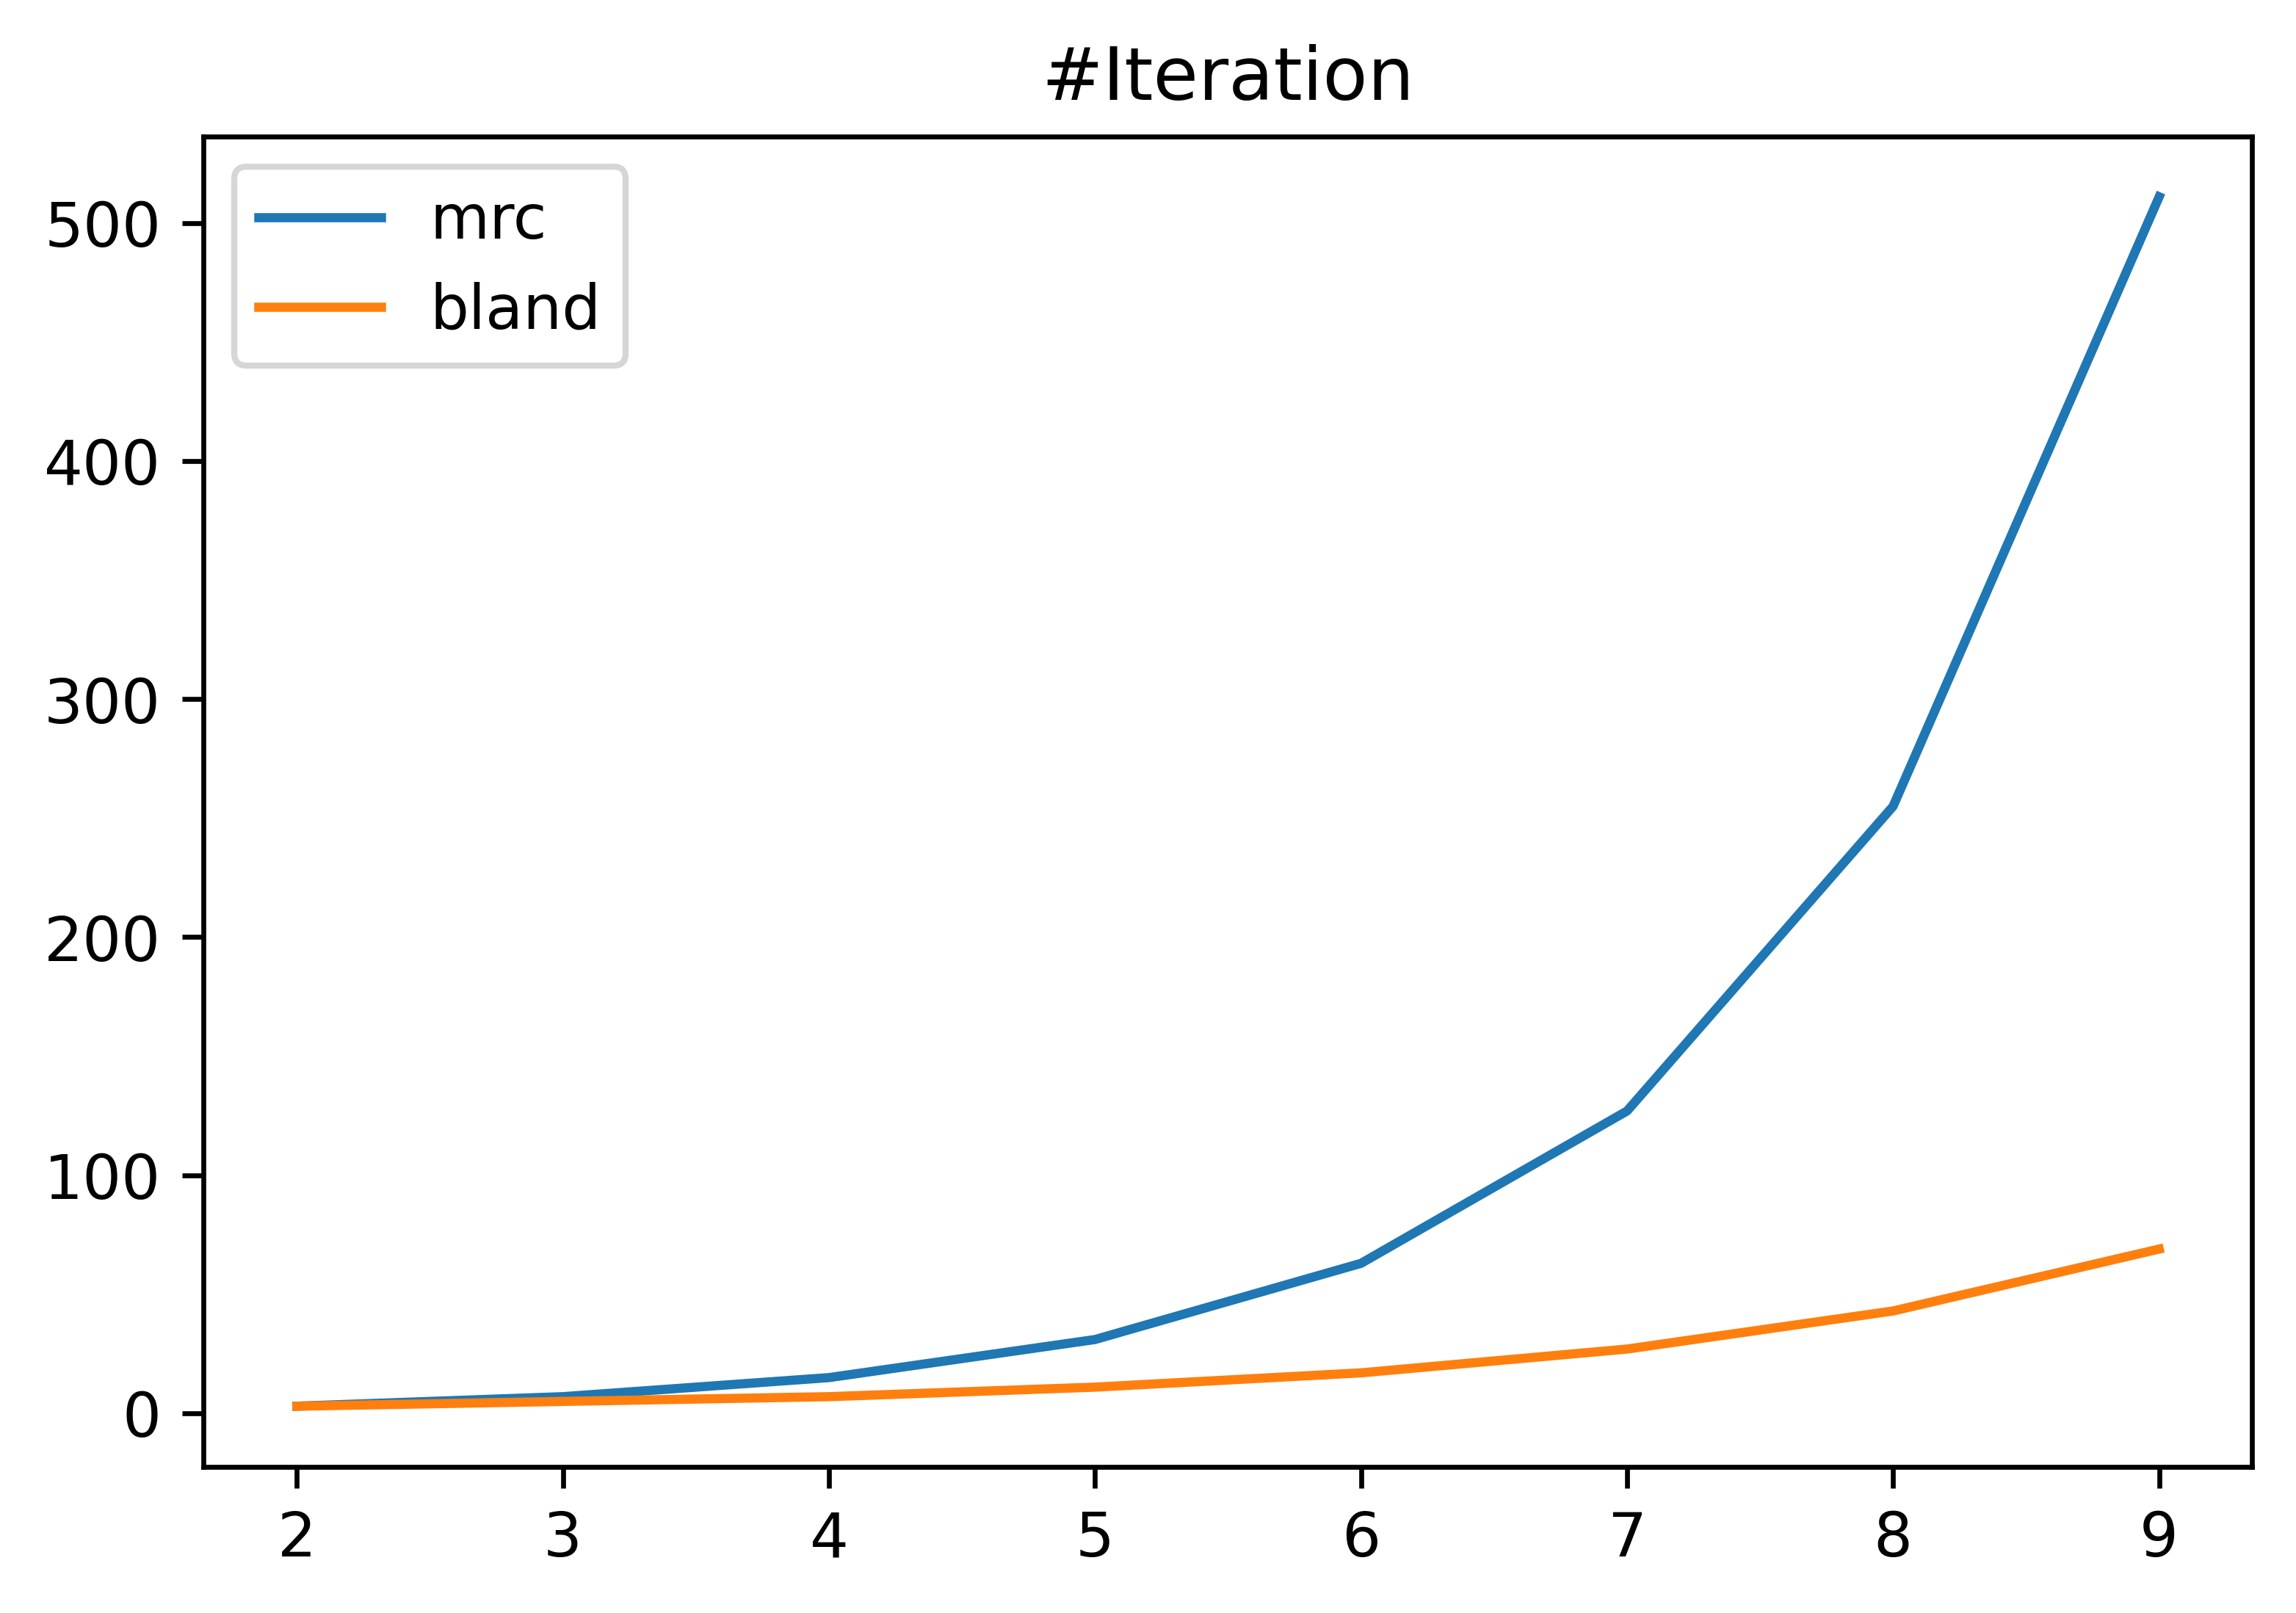

In [25]:
fig = plt.figure(dpi=800)
plt.plot(x, mrc_iter_mx, label="mrc")
plt.plot(x, bland_iter_mx, label="bland")
plt.title("#Iteration")
plt.legend()
plt.savefig("cmp_iter.jpg")
plt.show()

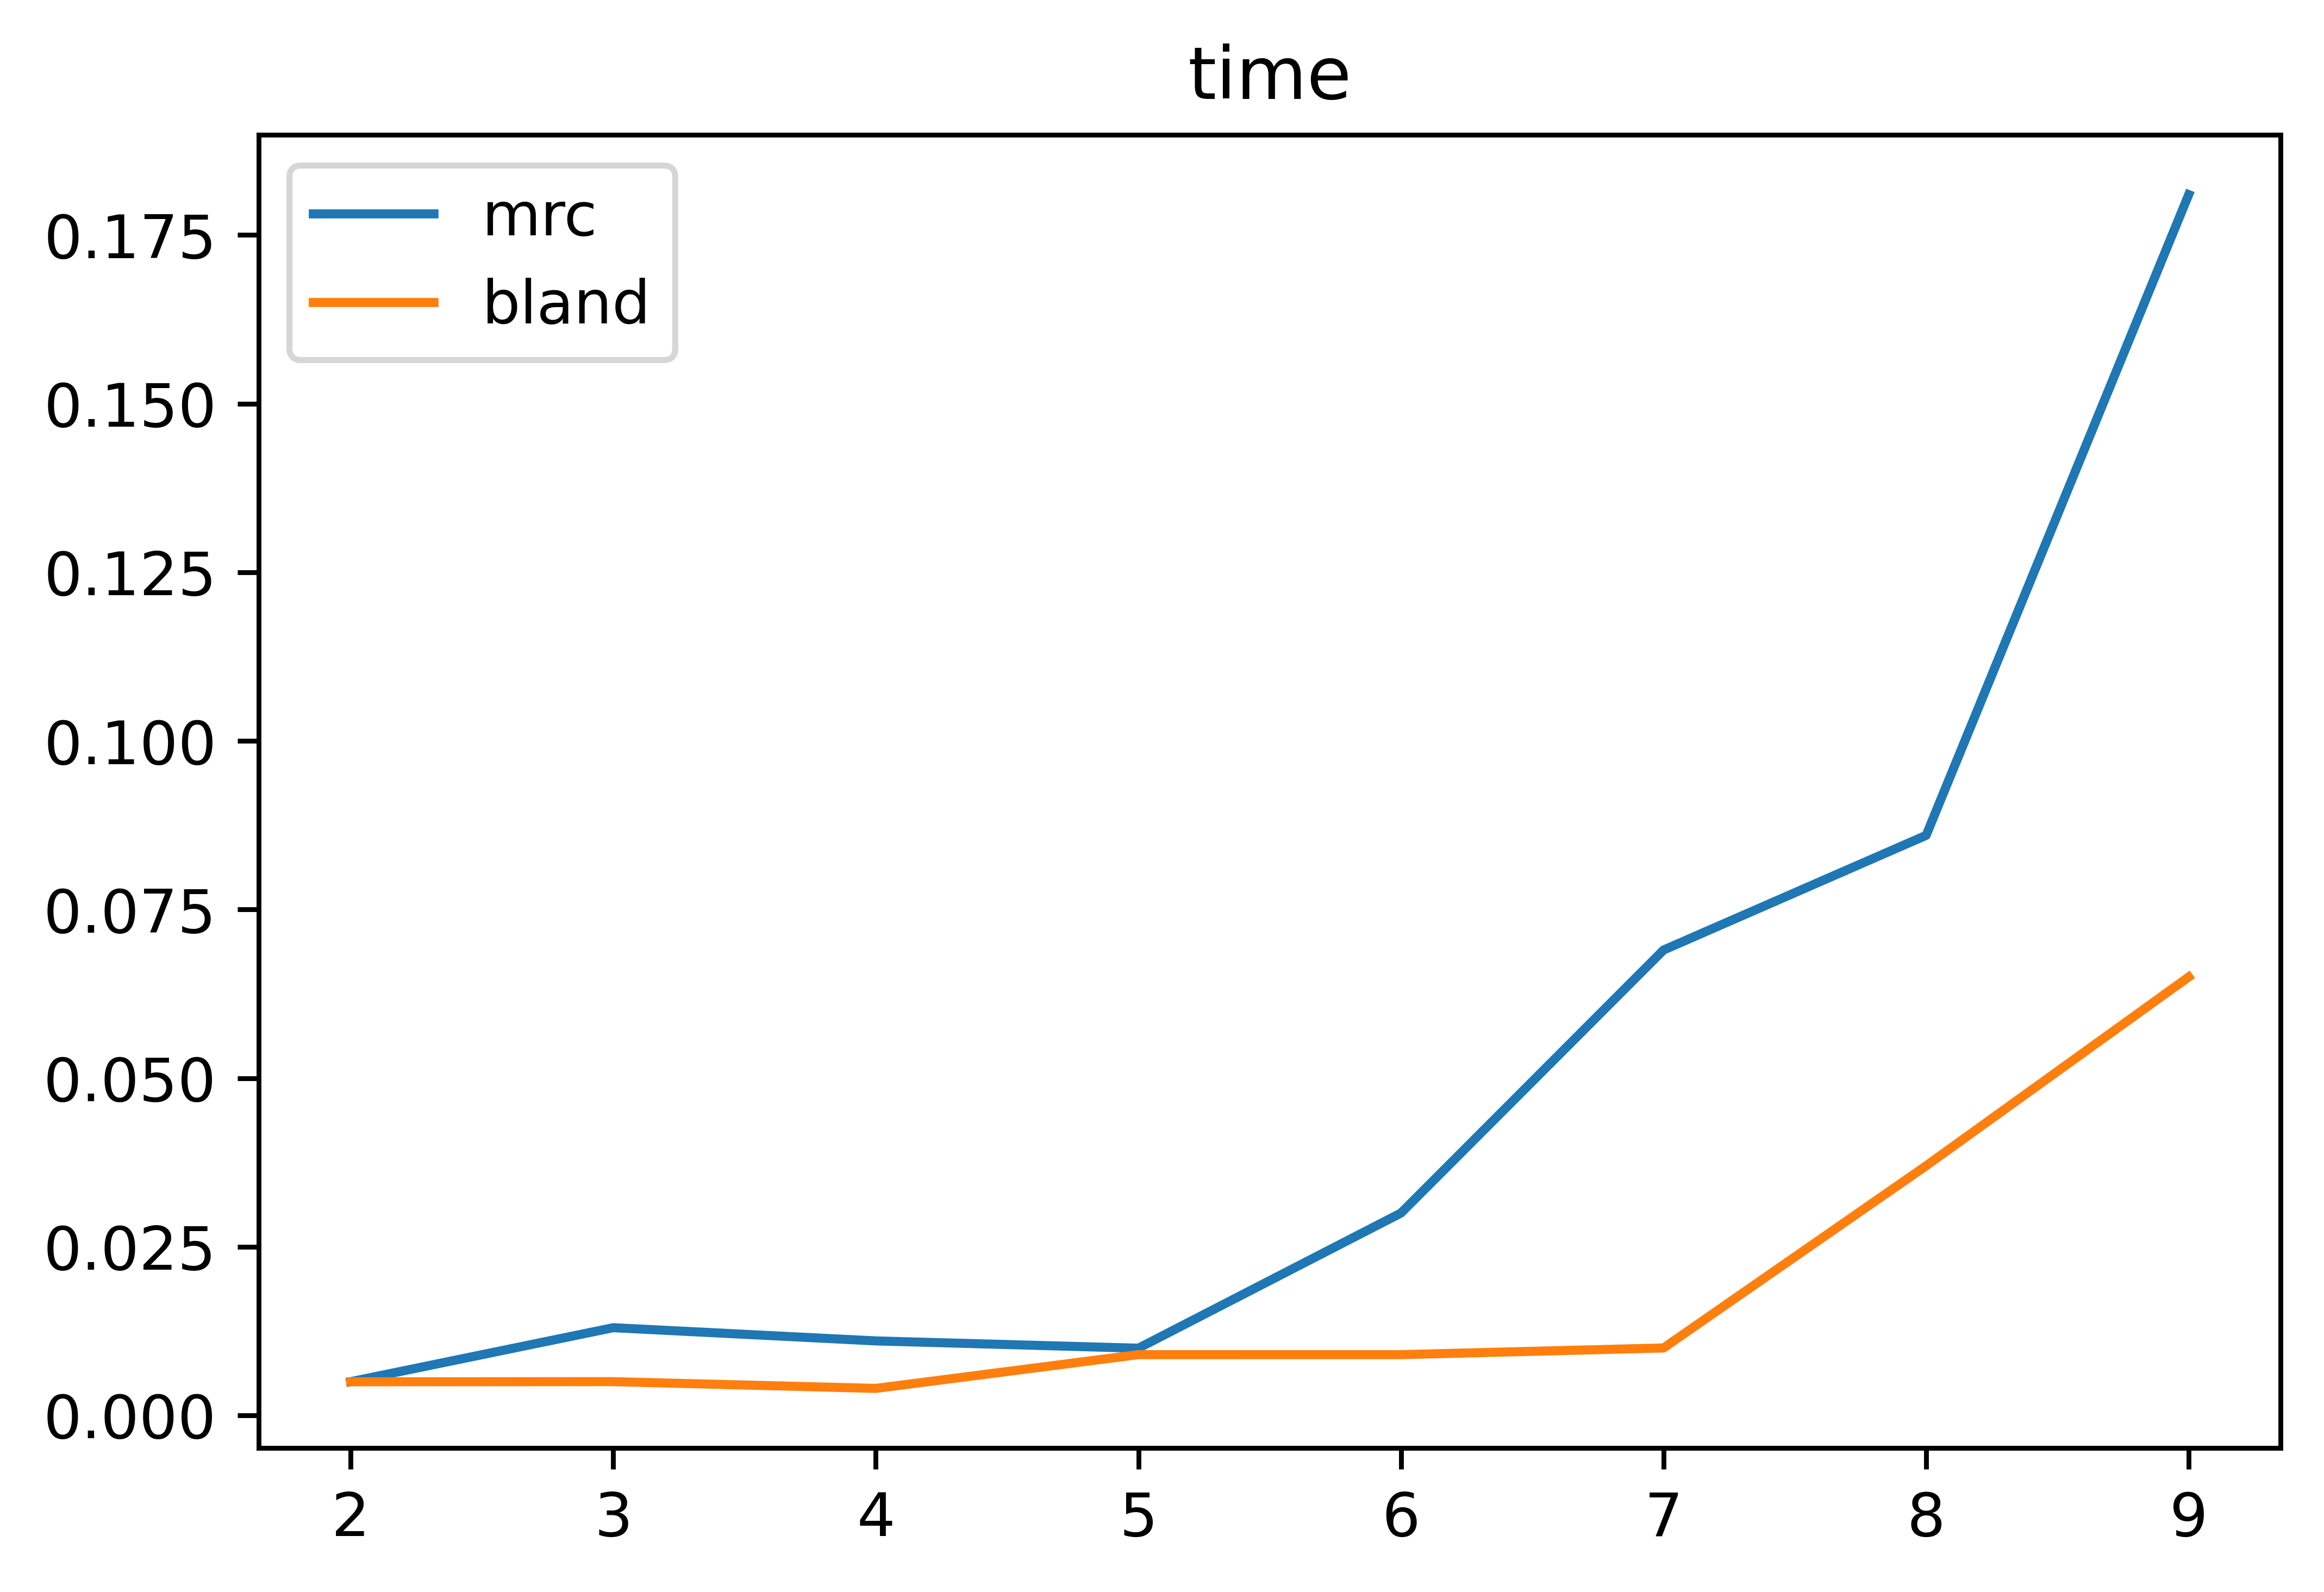

In [23]:
fig = plt.figure(dpi=800)
plt.plot(x, mrc_timelist, label='mrc')
plt.plot(x, bland_timelist, label ='bland')
plt.title("time")
plt.legend()
plt.savefig("cmp_time.jpg")
plt.show()

##  Food dataset

In [29]:
food = pd.read_excel("diet.xlsx")
food.head()

,Foods,Price/ Serving,Serving Size,Calories,Cholesterol mg,Total_Fat g,Sodium mg,Carbohydrates g,Dietary_Fiber g,Protein g,Vit_A IU,Vit_C IU,Calcium mg,Iron mg
0,Frozen Broccoli,0.16,10 Oz Pkg,73.8,0.0,0.8,68.2,13.6,8.5,8.0,5867.4,160.2,159.0,2.3
1,"Carrots,Raw",0.07,1/2 Cup Shredded,23.7,0.0,0.1,19.2,5.6,1.6,0.6,15471.0,5.1,14.9,0.3
2,"Celery, Raw",0.04,1 Stalk,6.4,0.0,0.1,34.8,1.5,0.7,0.3,53.6,2.8,16.0,0.2
3,Frozen Corn,0.18,1/2 Cup,72.2,0.0,0.6,2.5,17.1,2.0,2.5,106.6,5.2,3.3,0.3
4,"Lettuce,Iceberg,Raw",0.02,1 Leaf,2.6,0.0,0.0,1.8,0.4,0.3,0.2,66.0,0.8,3.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,"New E Clamchwd,W/Mlk",0.99,1 C (8 Fl Oz),163.7,22.3,6.6,992.0,16.6,1.5,9.5,163.7,3.5,186.0,1.5
62,"Crm Mshrm Soup,W/Mlk",0.65,1 C (8 Fl Oz),203.4,19.8,13.6,1076.3,15.0,0.5,6.1,153.8,2.2,178.6,0.6
63,"Beanbacn Soup,W/Watr",0.67,1 C (8 Fl Oz),172.0,2.5,5.9,951.3,22.8,8.6,7.9,888.0,1.5,81.0,2.0
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
price = food['Price/ Serving'].values[:-2]
print(price.shape)

(64,)


In [68]:
min_intake = food[food['Foods']=='Minimum daily intake'].values[0][3:]
print(min_intake)

[1500.0 30.0 20.0 800.0 130.0 125.0 60.0 1000.0 400.0 700.0 10.0]


In [55]:
nutritions = food.values[:-2,3:]
print(nutritions.shape)

(64, 11)


### dual :

$obj : \text{min} \text{ }(\textbf{price}^T*\textbf{x})$

$\text{nutritions}^T*\textbf{x}\geq  \textbf{min\_intake}$

$\textbf{x}\geq 0$

### primal: 

$obj: \text{max} \text{ } (\textbf{min\_intake}^T*{\textbf{y}})$

$\text{nutritions}*{\textbf{y}} \leq  \textbf{price}$

${\textbf{y}}\geq 0$

In [74]:
def primal_solve(dual_edge_strategy):
    s = time.time()
    r = linprog(
        c = -min_intake,
        A_ub = nutritions,
        b_ub = price,
        method='highs-ds',
        options={
            'simplex_dual_edge_weight_strategy' :dual_edge_strategy
        }
    )
    e = time.time()
    return r, e-s


In [75]:
dual_edge_strategies = ['steepest','dantzig','devex'] 

In [76]:
result = {
    'steepest':{},
    'dantzig':{},
    'devex':{}
}

In [77]:
for s in dual_edge_strategies:
    r, t = primal_solve(s)
    result[s]['time'] = t
    result[s]['min_price'] = -r['fun']
    result[s]['iters']=r['nit']

In [78]:
cmp_result = pd.DataFrame(
    result
)
cmp_result.head()

,steepest,dantzig,devex
time,0.005007,0.004992,0.001995
min_price,1.570313,1.570313,1.570313
iters,13.000000,7.000000,8.000000


In [80]:
cmp_result.to_csv(
    'dual_edge_strategies.csv', encoding='utf-8'
)